## Clustering Project: Drivers of Error in Zillow Zestimates

Data Science Team Members: Gabby Broussard and Barbara Marques

#### Project Summary:

Our team has been asked to analyze Zillow data on single unit/single family properties with transaction dates in 2017 to discover the drivers of errors in Zillow's zestimates. 

Data Source: Zillow database on Codeup's data server.

#### Project Goals:
- Build out caching in your python scripts to store the data locally as a csv in order to speed up future data acquisition.
- Deliver a notebook presentation of methods used to isolate drivers of error in Zillow Zestimates

#### Initial Questions: 


<a id='back'></a>
### Quick Links to Sections within this Notebook

- [Acquire Data](#AD)
- [Prepare Data](#PD)
- [Split Data](#SD)
- [Explore Data](#Explore)
- [Hypothesis Testing](#Hypo)
- [Scale Data](#Scale)
- [Create a Baseline Model](#Baseline)
- [Model Data (train & validate)](#Model)
- [Model on Test Data](#Test)
- [Model Visualizations](#Visual)
- [Recommendations & Key Takeaways](#Concl)

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
import wrangle
from acquire import get_zillow_data
# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

#Modeling Imports
from sklearn.model_selection import learning_curve
from sklearn.cluster import KMeans, dbscan
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures


pd.options.display.float_format = '{:20,.2f}'.format
pd.set_option('display.max_columns', 80)

<a id='AD'></a>
## Acquire
[back to top](#back)

In [2]:
acquired_zillow =get_zillow_data()

In [3]:
acquired_zillow.shape

(52519, 69)

In [4]:
acquired_zillow.describe()

,Unnamed: 0,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror,buildingclassdesc
count,"52,519.00","52,519.00","52,519.00","13,646.00",70.00,47.00,"52,519.00","52,519.00",0.00,"33,797.00","52,368.00",390.00,"4,386.00","52,424.00","52,257.00",2.00,0.00,"4,386.00",165.00,"52,519.00","7,242.00","52,368.00","18,020.00","18,020.00","1,515.00","33,941.00","52,519.00","52,519.00","52,143.00","11,097.00",867.00,444.00,"1,071.00","10,010.00","52,519.00","52,519.00","51,482.00","52,519.00","19,042.00","52,493.00","52,519.00",47.00,"6,724.00",76.00,"33,906.00","1,938.00",65.00,"52,390.00","14,566.00",81.00,"52,434.00","52,518.00","52,519.00","52,517.00","52,515.00","2,082.00","52,396.00","52,519.00",0.00
mean,"26,259.00","1,497,295.81","12,995,228.09",2.44,7.10,678.98,2.30,3.30,nan,6.27,2.30,66.00,"1,545.78","1,922.54","1,924.72","1,180.00",nan,"1,566.52","1,241.08","6,049.13",1.21,2.24,1.95,495.69,1.00,3.97,"34,023,083.91","-118,194,356.12","11,475.45",1.00,518.32,1.00,1.00,1.00,261.00,"60,494,406.93","33,484.45","2,524.97","180,224.46","96,636.45",1.89,7.00,1.01,5.97,1.00,337.64,229.74,"1,963.43",1.41,1.00,"196,395.60","529,259.99","2,016.00","333,184.86","6,448.59",14.10,"60,502,364,233,855.30",0.02,nan
std,"15,161.07","859,396.93","3,346,502.73",3.85,2.67,711.83,1.02,0.95,nan,1.72,1.02,0.00,674.80,"1,003.89","1,003.81",169.71,nan,744.38,776.96,21.03,0.51,0.99,0.55,157.32,0.00,2.56,"274,353.69","356,745.57","86,934.14",0.00,156.47,0.00,0.00,0.00,0.08,"208,714.01","49,142.24",803.82,"159,813.91","4,601.74",3.14,0.00,0.14,0.23,0.03,249.96,190.83,23.15,0.54,0.00,"254,188.60","751,455.76",0.00,"570,199.18","8,751.05",2.39,"1,857,672,371,242.34",0.18,nan
min,0.00,349.00,"10,711,855.00",1.00,2.00,38.00,0.00,0.00,nan,1.00,1.00,66.00,184.00,128.00,128.00,"1,060.00",nan,184.00,380.00,"6,037.00",1.00,1.00,0.00,0.00,1.00,1.00,"33,340,620.00","-119,475,416.00",236.00,1.00,24.00,1.00,1.00,1.00,261.00,"60,371,011.10","3,491.00","1,286.00","6,952.00","95,982.00",0.00,7.00,1.00,4.00,1.00,11.00,12.00,"1,878.00",1.00,1.00,129.00,"1,000.00","2,016.00",161.00,49.18,4.00,"60,371,011,101,000.00",-4.66,nan
25%,"13,129.50","757,861.50","11,507,727.50",1.00,7.00,263.50,2.00,3.00,nan,5.00,2.00,66.00,"1,151.00","1,268.00","1,270.00","1,120.00",nan,"1,152.00",784.00,"6,037.00",1.00,2.00,2.00,426.00,1.00,2.00,"33,827,127.50","-118,400,864.50","5,584.00",1.00,424.50,1.00,1.00,1.00,261.00,"60,374,012.02","12,447.00","1,286.00","41,131.00","96,206.00",0.00,7.00,1.00,6.00,1.00,200.00,72.00,"1,950.00",1.00,1.00,"77,038.00","193,417.25","2,016.00","75,815.00","2,652.09",14.00,"60,374,013,031,011.00",-0.02,nan
50%,"26,259.00","1,500,862.00","12,575,721.00",1.00,7.00,512.00,2.00,3.00,nan,6.00,2.00,66.00,"1,410.00","1,658.00","1,660.00","1,180.00",nan,"1,414.00","1,008.00","6,037.00",1.00,2.00,2.00,462.00,1.00,2.00,"34,024,351.00","-118,153,319.00","6,843.00",1.00,500.00,1.00,1.00,1.00,261.00,"60,376,203.01","24,812.00","3,101.00","118,208.00","96,414.00",0.00,7.00,1.00,6.00,1.00,280.00,180.00,"1,961.00",1.00,1.00,"131,661.50","373,166.50","2,016.00","217,720.00","4,643.29",15.00,"60,376,203,014,006.00",0.01,nan
75%,"39,388.50","2

In [5]:
null_counts = acquired_zillow.isnull().sum().sort_values(ascending=False)
null_counts

finishedsquarefeet15    52519
buildingclassdesc       52519
buildingclasstypeid     52519
finishedsquarefeet13    52517
storydesc               52472
                        ...  
assessmentyear              0
logerror                    0
transactiondate             0
propertylandusedesc         0
Unnamed: 0                  0
Length: 69, dtype: int64

### Takeaways:
##### There are numerous null values that need to be handled
#### Columns with too many nulls need to be dropped from the data frame.
##### There are many outliers so they either need to be removed or handled by using a RobustScaler when scaling the data.

<a id='PD'></a>
## Prepare

[back to top](#back)

In [6]:
df= wrangle.wrangle_zillow()

In [7]:
df.head() 

,parcelid,bathrooms,bedrooms,buildingquality,square_feet,fips,latitude,longitude,lot_size,regionidcity,regionidcounty,regionidzip,roomcnt,unit_count,age,structure_tax_value,tax_value,assessmentyear,land_tax_value,taxamount,logerror,transactiondate,heating_system,county,age_bin,taxrate,acres,acres_bin,tax_value_bin,land_tax_value_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,cola
0,10711855,2.00,3.00,8.00,"2,107.00",6037,"34,222,559.00","-118,617,387.00","9,158.00","12,447.00","3,101.00","96,339.00",0.00,1.00,45.00,"249,655.00","624,139.00","2,016.00","374,484.00","7,659.36",-0.01,2017-07-07,Central,Los_Angeles,40-50,1.23,0.21,0.20,"$650,000","$450,000",0.50,118.49,0.40,40.89,20-49,0.67,1
1,10711877,2.00,4.00,8.00,"1,882.00",6037,"34,220,261.00","-118,616,409.00","9,035.00","12,447.00","3,101.00","96,339.00",0.00,1.00,45.00,"253,000.00","660,000.00","2,016.00","407,000.00","8,123.91",0.02,2017-08-29,Central,Los_Angeles,40-50,1.23,0.21,0.20,"$900,000","$450,000",0.40,134.43,0.40,45.05,20-49,0.50,1
2,10711888,2.00,4.00,8.00,"1,882.00",6037,"34,222,491.00","-118,616,854.00","9,800.00","12,447.00","3,101.00","96,339.00",0.00,1.00,45.00,"257,591.00","542,923.00","2,016.00","285,332.00","6,673.24",0.08,2017-04-04,Central,Los_Angeles,40-50,1.23,0.22,0.20,"$550,000","$350,000",0.40,136.87,0.40,29.12,20-49,0.50,1
3,10711910,2.00,3.00,8.00,"1,477.00",6037,"34,221,864.00","-118,615,739.00","11,285.00","12,447.00","3,101.00","96,339.00",0.00,1.00,57.00,"57,968.00","78,031.00","2,016.00","20,063.00","1,116.46",-0.04,2017-03-17,Central,Los_Angeles,50-60,1.43,0.26,0.30,"< $80,000","< $50,000",0.30,39.25,0.10,1.78,1,0.67,1
4,10711923,2.00,4.00,8.00,"1,918.00",6037,"34,220,619.00","-118,615,253.00","11,239.00","12,447.00","3,101.00","96,339.00",0.00,1.00,57.00,"167,869.00","415,459.00","2,016.00","247,590.00","5,239.85",-0.01,2017-03-24,Central,Los_Angeles,50-60,1.26,0.26,0.30,"$450,000","$250,000",0.40,87.52,0.30,22.03,20-49,0.50,1


In [8]:
# look at the first 5 rows of our new dataframe, transposed
df.head().T

,0,1,2,3,4
parcelid,10711855,10711877,10711888,10711910,10711923
bathrooms,2.00,2.00,2.00,2.00,2.00
bedrooms,3.00,4.00,4.00,3.00,4.00
buildingquality,8.00,8.00,8.00,8.00,8.00
square_feet,"2,107.00","1,882.00","1,882.00","1,477.00","1,918.00"
fips,6037,6037,6037,6037,6037
latitude,"34,222,559.00","34,220,261.00","34,222,491.00","34,221,864.00","34,220,619.00"
longitude,"-118,617,387.00","-118,616,409.00","-118,616,854.00","-118,615,739.00","-118,615,253.00"
lot_size,"9,158.00","9,035.00","9,800.00","11,285.00","11,239.00"
regionidcity,"12,447.00","12,447.00","12,447.00","12,447.00","12,447.00"


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50819 entries, 0 to 52504
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   parcelid                   50819 non-null  int64   
 1   bathrooms                  50819 non-null  float64 
 2   bedrooms                   50819 non-null  float64 
 3   buildingquality            50819 non-null  float64 
 4   square_feet                50819 non-null  float64 
 5   fips                       50819 non-null  int64   
 6   latitude                   50819 non-null  float64 
 7   longitude                  50819 non-null  float64 
 8   lot_size                   50819 non-null  float64 
 9   regionidcity               50819 non-null  float64 
 10  regionidcounty             50819 non-null  float64 
 11  regionidzip                50819 non-null  float64 
 12  roomcnt                    50819 non-null  float64 
 13  unit_count                 5081

In [10]:
#There are no remaining null values

df.isna().sum().sum()

2213

### Creating some new features:
- bins for: age, square feet
- tax rate
- bath/bed ratio:  (bathroom count / bedroom count)
- acres (lotsizesquarefeet/43560)
- dollar per square foot
- within city of Los Angeles


In [11]:
df.head().T

,0,1,2,3,4
parcelid,10711855,10711877,10711888,10711910,10711923
bathrooms,2.00,2.00,2.00,2.00,2.00
bedrooms,3.00,4.00,4.00,3.00,4.00
buildingquality,8.00,8.00,8.00,8.00,8.00
square_feet,"2,107.00","1,882.00","1,882.00","1,477.00","1,918.00"
fips,6037,6037,6037,6037,6037
latitude,"34,222,559.00","34,220,261.00","34,222,491.00","34,221,864.00","34,220,619.00"
longitude,"-118,617,387.00","-118,616,409.00","-118,616,854.00","-118,615,739.00","-118,615,253.00"
lot_size,"9,158.00","9,035.00","9,800.00","11,285.00","11,239.00"
regionidcity,"12,447.00","12,447.00","12,447.00","12,447.00","12,447.00"


In [12]:
df.describe()

,parcelid,bathrooms,bedrooms,buildingquality,square_feet,fips,latitude,longitude,lot_size,regionidcity,regionidcounty,regionidzip,roomcnt,unit_count,age,structure_tax_value,tax_value,assessmentyear,land_tax_value,taxamount,logerror,taxrate,acres,acres_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,bath_bed_ratio,cola
count,"50,819.00","50,819.00","50,819.00","50,819.00","50,819.00","50,819.00","50,819.00","50,819.00","50,819.00","50,819.00","50,819.00","50,819.00","50,819.00","50,819.00","50,819.00","50,819.00","50,819.00","50,819.00","50,819.00","50,819.00","50,819.00","50,819.00","50,819.00","50,819.00","50,819.00","50,819.00","50,819.00","50,819.00","50,819.00","50,819.00"
mean,"12,961,988.63",2.28,3.30,6.16,"1,890.06","6,049.21","34,021,696.06","-118,193,277.09","9,817.69","33,547.12","2,524.00","96,640.75",1.92,1.00,53.87,"185,360.45","494,659.84","2,016.00","309,299.39","6,030.21",0.02,1.33,0.23,0.17,0.39,89.39,0.28,47.25,0.70,0.22
std,"2,192,354.52",0.96,0.91,1.36,907.21,21.13,"272,994.72","355,631.91","20,784.28","49,280.87",803.66,"4,676.38",3.16,0.00,22.87,"192,985.80","503,547.32",0.00,"361,072.59","5,813.63",0.17,0.36,0.48,0.10,0.18,56.31,0.15,65.85,0.23,0.42
min,"10,711,855.00",1.00,1.00,1.00,500.00,"6,037.00","33,340,620.00","-119,475,265.00",236.00,"3,491.00","1,286.00","95,982.00",0.00,1.00,1.00,148.00,"3,254.00","2,016.00","2,250.00",49.18,-4.66,0.01,0.01,0.00,0.00,0.04,0.00,0.03,0.20,0.00
25%,"11,517,066.50",2.00,3.00,6.00,"1,266.00","6,037.00","33,827,301.00","-118,396,468.50","5,585.00","12,447.00","1,286.00","96,206.00",0.00,1.00,39.00,"76,786.00","191,520.50","2,016.00","73,833.00","2,627.88",-0.02,1.16,0.13,0.10,0.30,54.61,0.20,9.28,0.50,0.00
50%,"12,591,550.00",2.00,3.00,6.00,"1,649.00","6,037.00","34,020,668.00","-118,151,539.00","6,832.00","24,812.00","3,101.00","96,415.00",0.00,1.00,57.00,"130,092.00","368,866.00","2,016.00","215,518.00","4,587.67",0.01,1.23,0.16,0.20,0.40,81.51,0.30,30.23,0.67,0.00
75%,"14,131,794.50",3.00,4.00,7.00,"2,275.00","6,059.00","34,186,063.50","-117,929,146.00","8,686.50","40,227.00","3,101.00","96,996.00",5.00,1.00,67.00,"220,309.00","608,352.50","2,016.00","404,186.00","7,225.28",0.04,1.37,0.20,0.20,0.50,112.34,0.40,59.61,0.80,0.00
max,"162,960,814.00",7.00,7.00,12.00,"8,909.00","6,111.00","34,818,767.00","-117,572,338.00","862,329.00","396,556.00","3,101.00","399,675.00",14.00,1.00,139.00,"3,097,672.00","4,993,132.00","2,016.00","4,847,224.00","72,122.20",3.39,9.81,19.80,0.70,0.90,"1,444.22",0.90,"1,604.53",3.00,1.00


(array([2.000e+00, 0.000e+00, 1.400e+01, 1.600e+01, 1.100e+02, 4.791e+04,
        2.575e+03, 1.000e+02, 8.300e+01, 9.000e+00]),
 array([-4.65542038, -3.85042393, -3.04542749, -2.24043104, -1.4354346 ,
        -0.63043816,  0.17455829,  0.97955473,  1.78455118,  2.58954762,
         3.39454407]),
 <BarContainer object of 10 artists>)

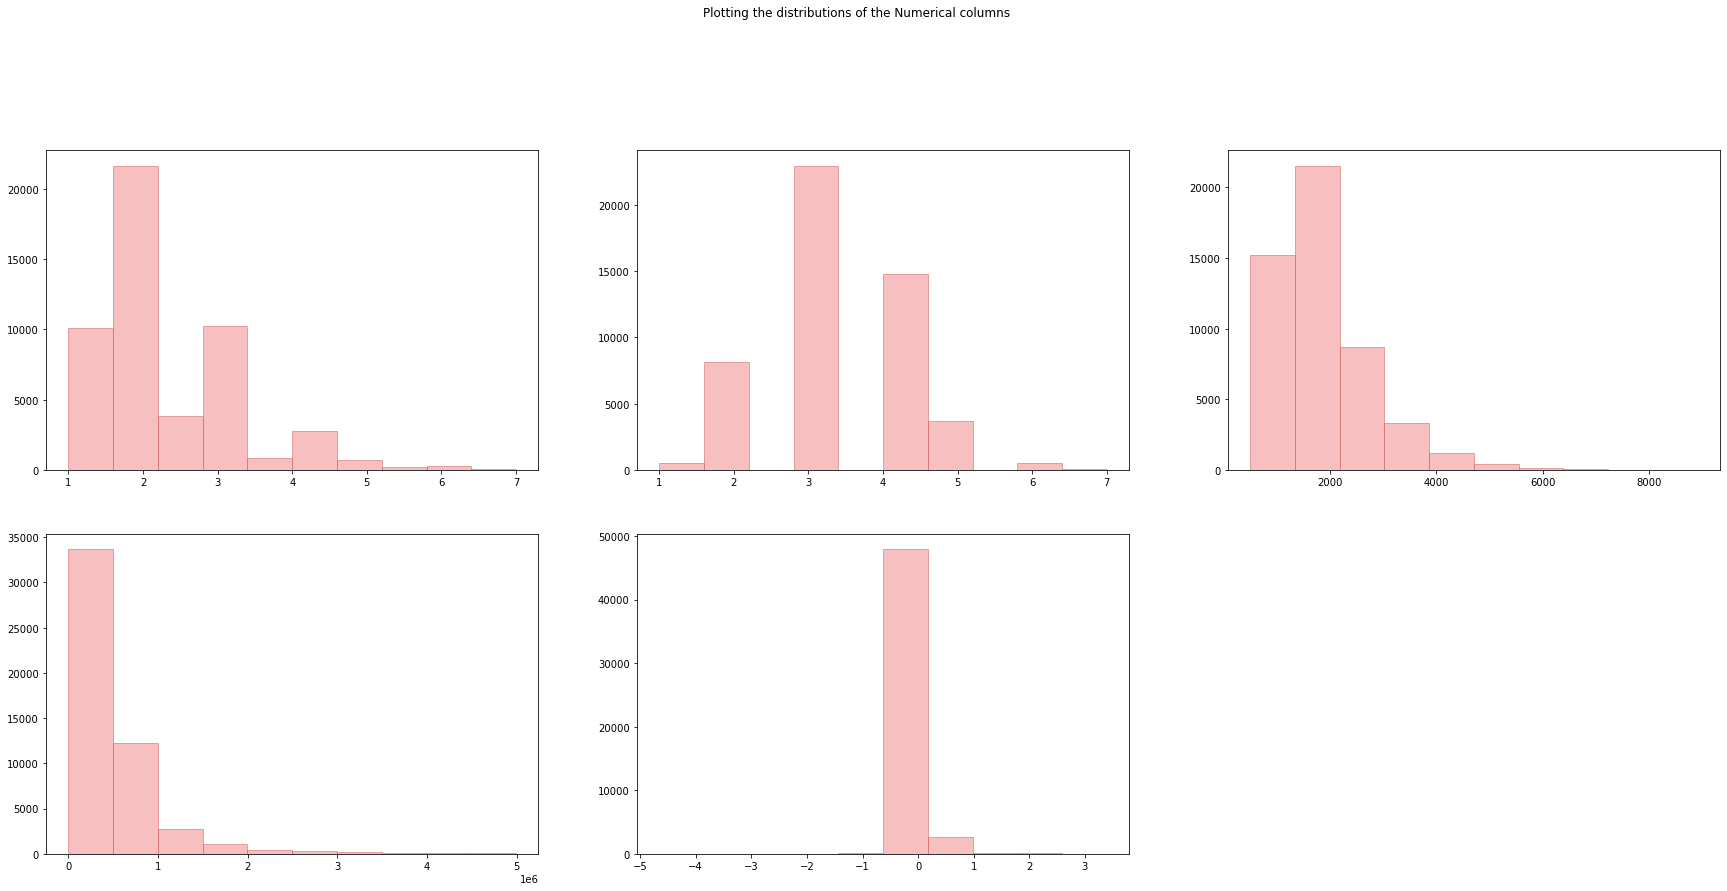

In [13]:
plt.figure(figsize=(30, 20))

plt.suptitle("Plotting the distributions of the Numerical columns")
# row, columns, index
plt.subplot(3, 3, 1)
plt.hist(df.bathrooms, edgecolor='indianred', alpha=0.5, color='lightcoral')
plt.subplot(3, 3, 2)
plt.hist(df.bedrooms, edgecolor='indianred', alpha=0.5, color='lightcoral')
plt.subplot(3, 3, 3)
plt.hist(df.square_feet, edgecolor='indianred', alpha=0.5, color='lightcoral')
plt.subplot(3, 3, 4)
plt.hist(df.tax_value, edgecolor='indianred', alpha=0.5, color='lightcoral')
plt.subplot(3, 3, 5)
plt.hist(df.logerror, edgecolor='indianred', alpha=0.5, color='lightcoral')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50819 entries, 0 to 52504
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   parcelid                   50819 non-null  int64   
 1   bathrooms                  50819 non-null  float64 
 2   bedrooms                   50819 non-null  float64 
 3   buildingquality            50819 non-null  float64 
 4   square_feet                50819 non-null  float64 
 5   fips                       50819 non-null  int64   
 6   latitude                   50819 non-null  float64 
 7   longitude                  50819 non-null  float64 
 8   lot_size                   50819 non-null  float64 
 9   regionidcity               50819 non-null  float64 
 10  regionidcounty             50819 non-null  float64 
 11  regionidzip                50819 non-null  float64 
 12  roomcnt                    50819 non-null  float64 
 13  unit_count                 5081

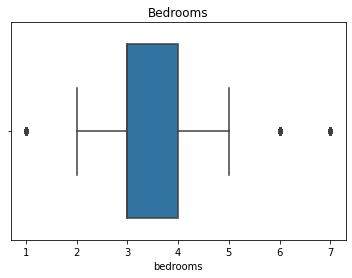

In [15]:
### Checking for Outliers:
sns.boxplot(df['bedrooms'])
plt.title('Bedrooms')
plt.show()

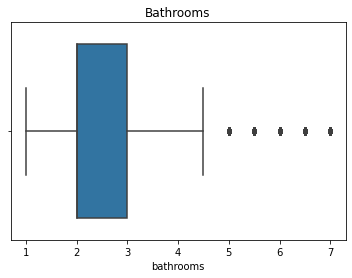

In [16]:
sns.boxplot(df['bathrooms'])
plt.title('Bathrooms')
plt.show()

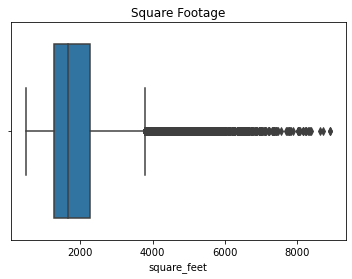

In [17]:
sns.boxplot(df['square_feet'])
plt.title('Square Footage')
plt.show()

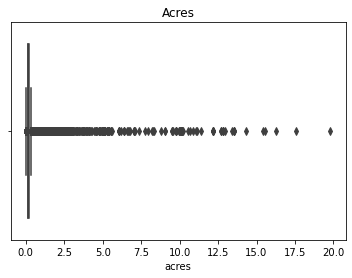

In [18]:
sns.boxplot(df['acres'])
plt.title('Acres')
plt.show()

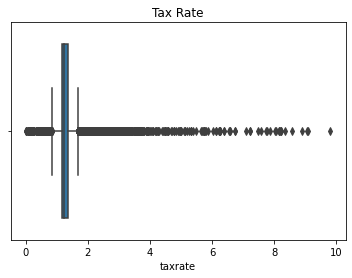

In [19]:
sns.boxplot(df['taxrate'])
plt.title('Tax Rate')
plt.show()

### Takeaways:  

Removing Outliers:

Remove extremes in bedrooms and baths (KEEP only 1-7 baths and 1-7 bedrooms)

remove square feet > 9000

remove lot size (acres) > 20 

Remove tax rate > 10% 

In [20]:
def remove_outliers(df):
    '''
    remove outliers in bed, bath, square feet, acres & tax rate
    '''

    return df[((df.bathrooms <= 7) & (df.bedrooms <= 7) &
               (df.bathrooms >= 1) & 
               (df.bedrooms >= 1) & 
               (df.acres <= 20) &
               (df.square_feet <= 9000) & 
               (df.taxrate <= 10)
              )]

In [21]:
df = remove_outliers(df)
df.head()

,parcelid,bathrooms,bedrooms,buildingquality,square_feet,fips,latitude,longitude,lot_size,regionidcity,regionidcounty,regionidzip,roomcnt,unit_count,age,structure_tax_value,tax_value,assessmentyear,land_tax_value,taxamount,logerror,transactiondate,heating_system,county,age_bin,taxrate,acres,acres_bin,tax_value_bin,land_tax_value_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,cola
0,10711855,2.00,3.00,8.00,"2,107.00",6037,"34,222,559.00","-118,617,387.00","9,158.00","12,447.00","3,101.00","96,339.00",0.00,1.00,45.00,"249,655.00","624,139.00","2,016.00","374,484.00","7,659.36",-0.01,2017-07-07,Central,Los_Angeles,40-50,1.23,0.21,0.20,"$650,000","$450,000",0.50,118.49,0.40,40.89,20-49,0.67,1
1,10711877,2.00,4.00,8.00,"1,882.00",6037,"34,220,261.00","-118,616,409.00","9,035.00","12,447.00","3,101.00","96,339.00",0.00,1.00,45.00,"253,000.00","660,000.00","2,016.00","407,000.00","8,123.91",0.02,2017-08-29,Central,Los_Angeles,40-50,1.23,0.21,0.20,"$900,000","$450,000",0.40,134.43,0.40,45.05,20-49,0.50,1
2,10711888,2.00,4.00,8.00,"1,882.00",6037,"34,222,491.00","-118,616,854.00","9,800.00","12,447.00","3,101.00","96,339.00",0.00,1.00,45.00,"257,591.00","542,923.00","2,016.00","285,332.00","6,673.24",0.08,2017-04-04,Central,Los_Angeles,40-50,1.23,0.22,0.20,"$550,000","$350,000",0.40,136.87,0.40,29.12,20-49,0.50,1
3,10711910,2.00,3.00,8.00,"1,477.00",6037,"34,221,864.00","-118,615,739.00","11,285.00","12,447.00","3,101.00","96,339.00",0.00,1.00,57.00,"57,968.00","78,031.00","2,016.00","20,063.00","1,116.46",-0.04,2017-03-17,Central,Los_Angeles,50-60,1.43,0.26,0.30,"< $80,000","< $50,000",0.30,39.25,0.10,1.78,1,0.67,1
4,10711923,2.00,4.00,8.00,"1,918.00",6037,"34,220,619.00","-118,615,253.00","11,239.00","12,447.00","3,101.00","96,339.00",0.00,1.00,57.00,"167,869.00","415,459.00","2,016.00","247,590.00","5,239.85",-0.01,2017-03-24,Central,Los_Angeles,50-60,1.26,0.26,0.30,"$450,000","$250,000",0.40,87.52,0.30,22.03,20-49,0.50,1


In [22]:
df.shape

(50819, 37)

<a id='SD'></a>
#### Splitting Data

[back to top](#back)

In [23]:
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.data_split(df,stratify_by='logerror')

In [24]:
X_train.shape, X_validate.shape, X_test.shape

((28458, 36), (12197, 36), (10164, 36))

In [25]:
y_train.shape, y_validate.shape, y_test.shape

((28458,), (12197,), (10164,))

In [26]:
train_validate, test = train_test_split(df, test_size=.30, random_state=123)
train, validate = train_test_split(train_validate, test_size=.20, random_state=123)

print("train observations: ", train.shape)
print("validate observations: ", validate.shape)
print("test observations: ", test.shape)

train observations:  (28458, 37)
validate observations:  (7115, 37)
test observations:  (15246, 37)


In [27]:
y_train = pd.DataFrame(y_train)
y_train

,logerror
41364,0.02
32738,-0.01
707,0.10
30071,0.09
27720,-0.03
...,...
201,0.03
48220,0.11
26489,-0.10
3575,-0.08


### Takeaways:
##### Dropped unneeded columns
##### Renamed columns to make easier to call
##### Created new features
##### Identified and removed outliers
##### Binned some variables to aid in exploration
##### Split data and scaled data
##### Data is ready for exploration


<a id='Explore'></a>
## Explore

[back to top](#back)

In [28]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28458 entries, 41364 to 42732
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   parcelid                   28458 non-null  int64   
 1   bathrooms                  28458 non-null  float64 
 2   bedrooms                   28458 non-null  float64 
 3   buildingquality            28458 non-null  float64 
 4   square_feet                28458 non-null  float64 
 5   fips                       28458 non-null  int64   
 6   latitude                   28458 non-null  float64 
 7   longitude                  28458 non-null  float64 
 8   lot_size                   28458 non-null  float64 
 9   regionidcity               28458 non-null  float64 
 10  regionidcounty             28458 non-null  float64 
 11  regionidzip                28458 non-null  float64 
 12  roomcnt                    28458 non-null  float64 
 13  unit_count                 

In [29]:
y_train.describe()

,logerror
count,"28,458.00"
mean,0.02
std,0.17
min,-4.66
25%,-0.02
50%,0.01
75%,0.04
max,3.18


#### Correlation Test: square feet/log error  <br>
𝐻0: There is no difference in log error based on a properties square footage. <font color = 'red'>  --> REJECTED  <font color = 'black'>
    
𝐻𝑎: Properties with a square footage less than 2800 square footage have a lower log error than larger properties. 

In [30]:
α = .05

x = X_train.square_feet
y = y_train.logerror

r, p = stats.pearsonr(x,y)


print("'r' correlation coefficient is", r)
print("p-value (probability of seeing the data given the null hypothesis is true) is ", p)

if p < α:
    print("We reject the null hypothesis that there is no difference in log error based on a properties square footage.")
else:
    print("We fail to reject the null hypothesis")

'r' correlation coefficient is 0.03656900596871775
p-value (probability of seeing the data given the null hypothesis is true) is  6.794488946994873e-10
We reject the null hypothesis that there is no difference in log error based on a properties square footage.


#### Correlation Test: age/log error  <br>
𝐻0 : There is no difference in median log error in properties built in different years. <font color = 'red'>  --> REJECTED  <font color = 'black'>
    
𝐻𝑎 : Properties that were built after 1975 have a higher median log error than properties built before 1975.
<br><br>

In [31]:
α = .05

x = X_train.age
y = y_train.logerror

r, p = stats.pearsonr(x,y)


print("'r' correlation coefficient is", r)
print("p-value (probability of seeing the data given the null hypothesis is true) is ", p)

if p < α:
    print("We reject the null hypothesis that there is no difference in log error based on a home's age.")
else:
    print("We fail to reject the null hypothesis")

'r' correlation coefficient is -0.02144078340490189
p-value (probability of seeing the data given the null hypothesis is true) is  0.000297796079538452
We reject the null hypothesis that there is no difference in log error based on a home's age.


#### Correlation Test: latitude/log error 

𝐻0 : There is no correlation between latitude and log error. <font color = 'red'>  --> REJECTED  <font color = 'black'>

𝐻𝑎 : Properties that are more southern have a higher log error.


In [32]:
α = .05

x = X_train.latitude
y = y_train.logerror

r, p = stats.pearsonr(x,y)


print("'r' correlation coefficient is", r)
print("p-value (probability of seeing the data given the null hypothesis is true) is ", p)

if p < α:
    print("We reject the null hypothesis that there is no difference in log error based on a home's latitude.")
else:
    print("We fail to reject the null hypothesis")

'r' correlation coefficient is -0.023547632085190603
p-value (probability of seeing the data given the null hypothesis is true) is  7.104942590256166e-05
We reject the null hypothesis that there is no difference in log error based on a home's latitude.


In [33]:
### Drop Columns not needed



Text(0.5, 0, 'Age of Home in years')

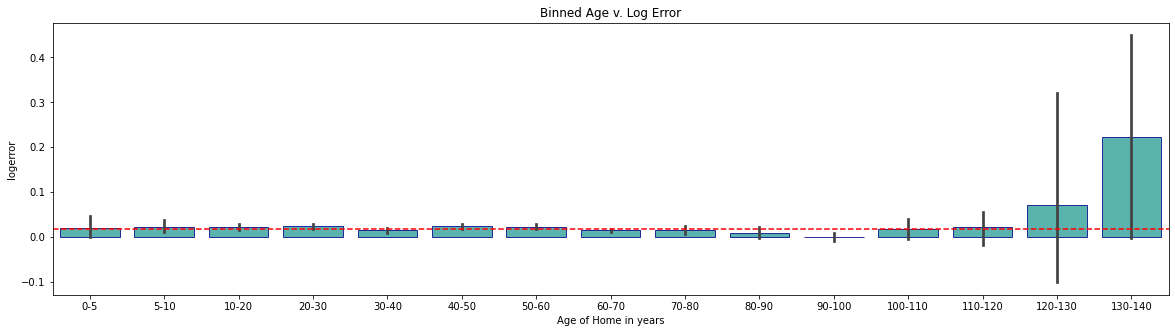

In [34]:
p = plt.figure(figsize=(20,5))
p = sns.barplot(X_train. age_bin, y_train.logerror, data=X_train, alpha=.8, color='lightseagreen', edgecolor = 'darkblue')
overall_rate = y_train.logerror.mean()
p = plt.axhline(overall_rate, ls='--', color='red', )
plt.title('Binned Age v. Log Error')
plt.xlabel("Age of Home in years")



 


Text(0.5, 1.0, 'Where are the Greatest Errors?   City of Los Angeles v. Log Error')

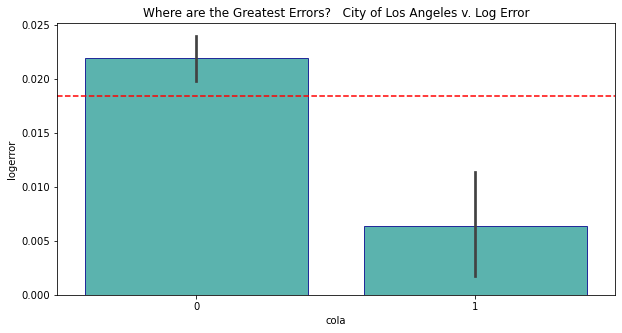

In [35]:
p = plt.figure(figsize=(10,5))
p = sns.barplot(X_train.cola, y_train.logerror, data=X_train, alpha=.8, color='lightseagreen', edgecolor = 'darkblue')
overall_rate = y_train.logerror.mean()
p = plt.axhline(overall_rate, ls='--', color='red', )
plt.title('Where are the Greatest Errors?   City of Los Angeles v. Log Error')




Text(0.5, 1.0, 'Where are the Greatest Errors?  Binned Acres v. Log Error')

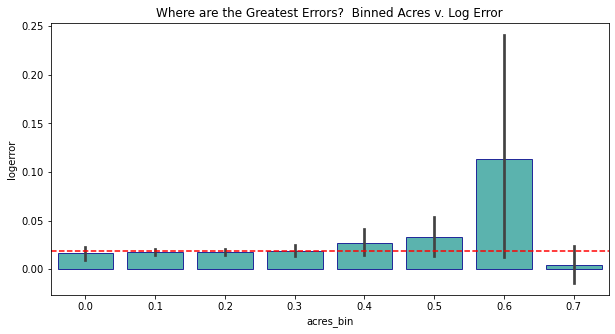

In [36]:
p = plt.figure(figsize=(10,5))
p = sns.barplot(X_train.acres_bin, y_train.logerror, data=X_train, alpha=.8, color='lightseagreen', edgecolor = 'darkblue')
overall_rate = y_train.logerror.mean()
p = plt.axhline(overall_rate, ls='--', color='red', )
plt.title('Where are the Greatest Errors?  Binned Acres v. Log Error')




Text(0.5, 1.0, 'Where are the Greatest Errors?  Binned Square Footage v. Log Error')

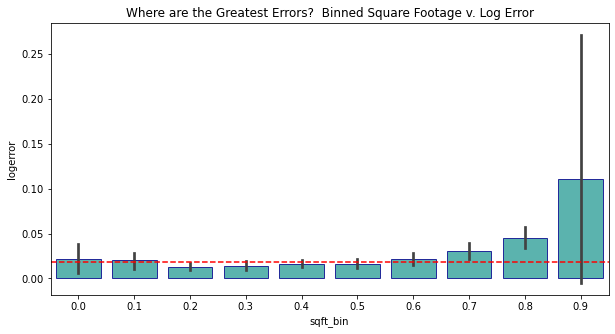

In [37]:
p = plt.figure(figsize=(10,5))
p = sns.barplot(X_train.sqft_bin, y_train.logerror, data=X_train, alpha=.8, color='lightseagreen', edgecolor = 'darkblue')
overall_rate = y_train.logerror.mean()
p = plt.axhline(overall_rate, ls='--', color='red', )
plt.title('Where are the Greatest Errors?  Binned Square Footage v. Log Error')




Text(0.5, 1.0, 'Where are the Greatest Errors?  Structure Dollar Per Square Foot v. Log Error')

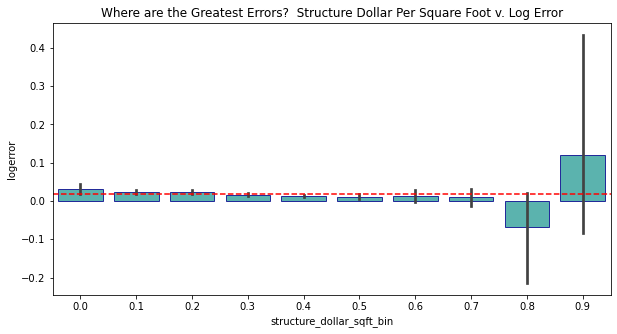

In [38]:
p = plt.figure(figsize=(10,5))
p = sns.barplot(X_train.structure_dollar_sqft_bin, y_train.logerror, data=X_train, alpha=.8, color='lightseagreen', edgecolor = 'darkblue')
overall_rate = y_train.logerror.mean()
p = plt.axhline(overall_rate, ls='--', color='red', )
plt.title('Where are the Greatest Errors?  Structure Dollar Per Square Foot v. Log Error')



Text(0.5, 1.0, 'Where are the Greatest Errors?  Lot Dollar Per Square Footage v. Log Error')

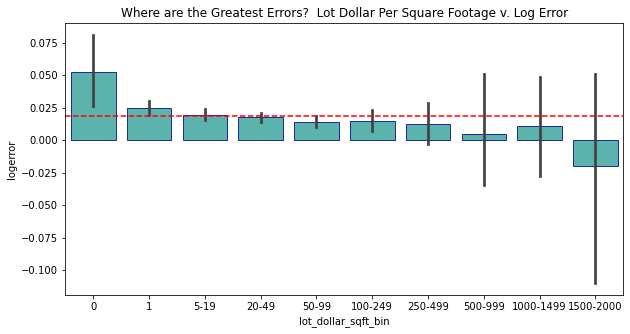

In [39]:
p = plt.figure(figsize=(10,5))
p = sns.barplot(X_train.lot_dollar_sqft_bin, y_train.logerror, data=X_train, alpha=.8, color='lightseagreen', edgecolor = 'darkblue')
overall_rate = y_train.logerror.mean()
p = plt.axhline(overall_rate, ls='--', color='red', )
plt.title('Where are the Greatest Errors?  Lot Dollar Per Square Footage v. Log Error')

Text(0.5, 1.0, 'Where are the Greatest Errors?  County v. Log Error')

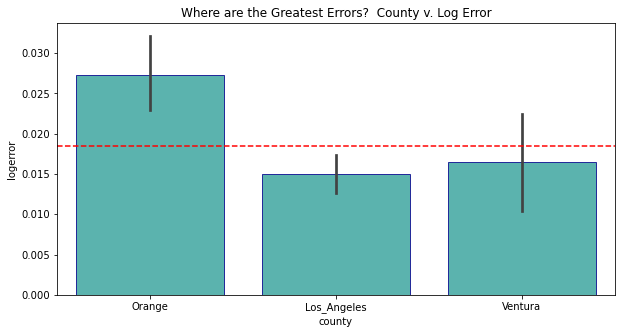

In [40]:
p = plt.figure(figsize=(10,5))
p = sns.barplot(X_train.county, y_train.logerror, data=X_train, alpha=.8, color='lightseagreen', edgecolor = 'darkblue')
overall_rate = y_train.logerror.mean()
p = plt.axhline(overall_rate, ls='--', color='red', )
plt.title('Where are the Greatest Errors?  County v. Log Error')

Text(0.5, 1.0, 'Where are the Greatest Errors?  Tax Value v. Log Error')

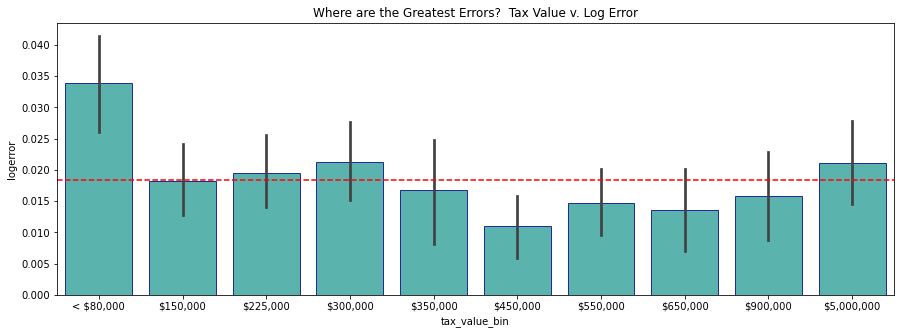

In [41]:
p = plt.figure(figsize=(15,5))
p = sns.barplot(X_train.tax_value_bin, y_train.logerror, data=X_train, alpha=.8, color='lightseagreen', edgecolor = 'darkblue')
overall_rate = y_train.logerror.mean()
p = plt.axhline(overall_rate, ls='--', color='red', )
plt.title('Where are the Greatest Errors?  Tax Value v. Log Error')

Text(0.5, 1.0, 'Where are the Greatest Errors? Land Tax Value v. Log Error')

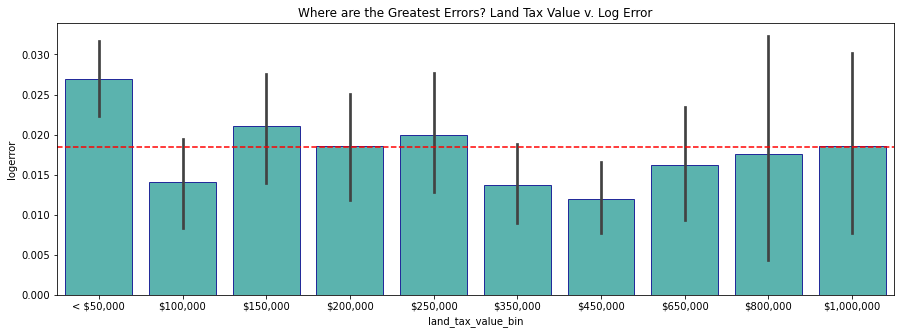

In [42]:
p = plt.figure(figsize=(15,5))
p = sns.barplot(X_train.land_tax_value_bin, y_train.logerror, data=X_train, alpha=.8, color='lightseagreen', edgecolor = 'darkblue')
overall_rate = y_train.logerror.mean()
p = plt.axhline(overall_rate, ls='--', color='red', )
plt.title('Where are the Greatest Errors? Land Tax Value v. Log Error')


<a id='Scale'></a>
### Scale Data

[back to top](#back)

<a id='Model'></a>

## Model

[back to top](#back)

<a id='Concl'></a>

## Conclusion

[back to top](#back)